In [1]:
# Importujeme si opět knihovny jako minule
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import tensorflow as tf
import keras

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")

from keras import layers
# %matplotlib ipympl

TensorFlow version: 2.16.2
Keras version: 3.5.0


In [2]:
# Informace o datasetu: 
# https://keras.io/api/datasets/california_housing/
from keras.datasets import california_housing

(train_data, train_target), (test_data, test_target) = california_housing.load_data(version="small")

feature_names = [
    "MedInc",
    "HouseAge",
    "AveRooms",
    "AveBedrms",
    "Population",
    "AveOccup",
    "Latitude",
    "Longitude"
]

target_names = ["MedianHouseValue"]

train_data.shape, test_data.shape

((480, 8), (120, 8))

In [3]:
train_target = train_target / 1000
test_target = test_target / 1000

"mean: {}, min: {}, max: {}".format(test_target.mean(), test_target.min(), test_target.max())

'mean: 196.15501403808594, min: 74.0999984741211, max: 500.0010070800781'

In [4]:
pd.DataFrame(train_data, columns=feature_names).head(10)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,-122.239998,37.730000,21.0,7031.0,1249.0,2930.0,1235.0,4.5213
1,-122.279999,37.849998,48.0,2063.0,484.0,1054.0,466.0,2.2625
2,-122.290001,37.820000,2.0,158.0,43.0,94.0,57.0,2.5625
3,-122.290001,37.810001,46.0,935.0,297.0,582.0,277.0,0.7286
4,-122.180000,37.759998,37.0,1575.0,358.0,933.0,320.0,2.2917
5,-122.230003,37.790001,48.0,1696.0,396.0,1481.0,343.0,2.0375
6,-122.279999,37.840000,52.0,729.0,160.0,395.0,155.0,1.6875
7,-122.279999,37.889999,52.0,2315.0,408.0,835.0,369.0,4.5893
8,-122.250000,37.810001,29.0,4656.0,1414.0,2304.0,1250.0,2.4912
9,-122.220001,37.810001,52.0,2927.0,402.0,1021.0,380.0,8.1564


In [5]:
from sklearn.model_selection import train_test_split
x_train, x_validate, y_train, y_validate = train_test_split(train_data, train_target, test_size=0.2)

x_train.shape, x_validate.shape

((384, 8), (96, 8))

In [6]:
def normalize(data):
    mean = data.mean(axis=0)
    std = data.std(axis=0)
    return (data - mean) / std

x_train = normalize(x_train)
x_validate = normalize(x_validate)

test_data = normalize(test_data)

In [7]:
from sklearn.model_selection import KFold

def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation="relu", input_shape=(train_data.shape[1],)),
        layers.Dense(64, activation="relu"),
        layers.Dense(1)
    ])

    model.compile(optimizer="adam", loss="mse", metrics=["mae"])
    return model

kf = KFold(n_splits=10)
for train_idx, valid_idx in kf.split(train_data, train_target):
    # print(train_idx.shape, valid_idx.shape)
    kf_x_train = normalize(train_data[train_idx])
    kf_x_validate = normalize(train_data[valid_idx])

    model = build_model()
    model.fit(
        kf_x_train, train_target[train_idx],
        validation_data=(kf_x_validate, train_target[valid_idx]),
        epochs=10,
        batch_size=8,
        verbose=0
    )
    model.evaluate(kf_x_validate, train_target[valid_idx], batch_size=8)
    # Ukládám si výsledky metriky a modely a nejlepší nakonec vyberu.

/Users/hradzpisku/Documents/Projects/UMIN/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 787us/step - loss: 3057.4739 - mae: 44.3464
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 529us/step - loss: 3707.6653 - mae: 51.8837
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step - loss: 4915.2651 - mae: 49.1092
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 536us/step - loss: 4009.1201 - mae: 48.5806
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 532us/step - loss: 4023.4246 - mae: 43.9195
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 518us/step - loss: 5292.8262 - mae: 61.4852
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step - loss: 2473.7664 - mae: 39.7671
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 533us/step - loss: 4873.9072 - mae: 56.7365
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 535us/step - loss: 2624.6831 - mae: 42.9149
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 537us/step - loss: 4544.6230 - mae: 51.2861


In [8]:
model = keras.Sequential([
    layers.Dense(128, input_shape=[x_train.shape[1]], activation="relu"),
    layers.Dense(128, activation="relu"),
    layers.Dense(1)
])

model.compile(
	optimizer="adam",
	loss="mse", # Mean Squared Error – loss function
    metrics=['mae'], 
        # Mean Absolute Error – regression metric
        # vzorec: sum(abs(y_true - y_pred)) / n
        # MAE 0,5 v tomto problému by znamenalo, že vaše předpovědi jsou v průměru o 500 dolarů nižší.
)

trained = model.fit(
    x_train, y_train,
    validation_data=(x_validate, y_validate),
    batch_size=4,
    epochs=300,
    verbose=False,
)

loss         496.075439
mae           17.289852
val_loss    1235.124268
val_mae       26.849922
Name: 299, dtype: float64

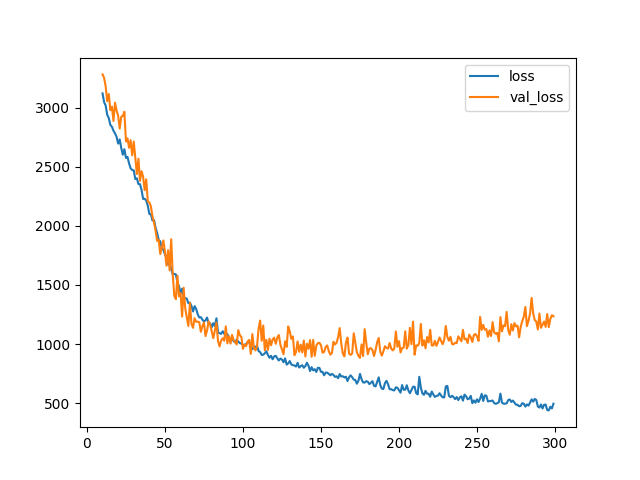

In [9]:
history = pd.DataFrame(trained.history)

history.loc[10:, ['loss', 'val_loss']].plot()
# history.loc[10:, ['mae', 'val_mae']].plot()

# V poslední epoše.
history.iloc[-1]

# Vidíme, že zhruba po 100 epoše se model začíná přeučovat

In [10]:
# Vyhodnocení modelu
results = model.evaluate(test_data, test_target, batch_size=32)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 829us/step - loss: 3589.9031 - mae: 38.8704


In [11]:
model = keras.Sequential([
    layers.Dense(128, input_shape=[x_train.shape[1]], activation="relu"),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(1)
])

model.compile(
	optimizer="adam",
	loss="mse",
    metrics=['mae'],
)

trained = model.fit(
    x_train, y_train,
    validation_data=(x_validate, y_validate),
    batch_size=16,
    epochs=500,
    verbose=False,
)

/Users/hradzpisku/Documents/Projects/UMIN/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


loss        1151.813232
mae           24.554314
val_loss    1233.222656
val_mae       25.779037
Name: 499, dtype: float64

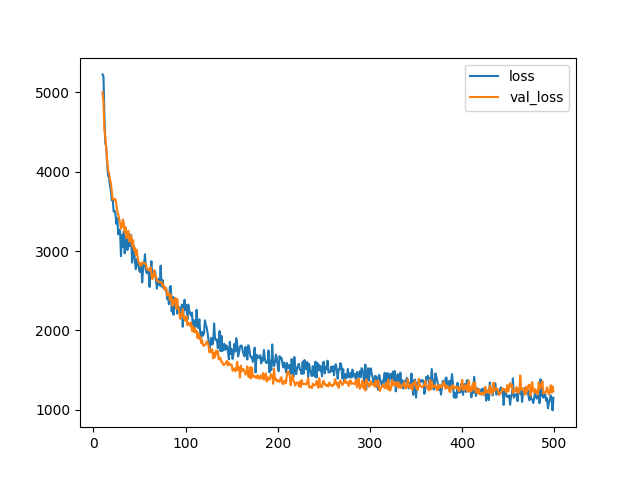

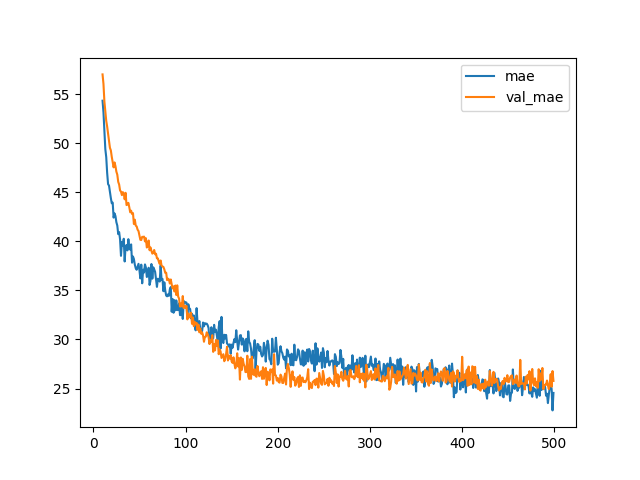

In [12]:
history = pd.DataFrame(trained.history)

history.loc[10:, ['loss', 'val_loss']].plot()
history.loc[10:, ['mae', 'val_mae']].plot()

# V poslední epoše.
history.iloc[-1]

In [13]:
# Vyhodnocení modelu
results = model.evaluate(test_data, test_target, batch_size=32)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3449.8730 - mae: 33.6223 
